In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CometLogger
from src.datasets.datasets import CPDDatasets

# from src.loss.loss import CPDLoss
from src.metrics.evaluation_pipelines import evaluation_pipeline
from src.models.core_models import BaseRnn
from src.models.cpd_models import CPDModel
from src.utils.fix_seeds import fix_seeds
from torch.utils.data import DataLoader

comet_ml is installed but `COMET_API_KEY` is not set.


# InDiD HAR

In [3]:
model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

args_config["learning"]["epochs"] = 100

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()

val_dataloader_shuffle = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [6]:
SEED = 0
fix_seeds(SEED)

core_model = BaseRnn(
    input_size=args_config["model"]["input_size"],
    hidden_dim=args_config["model"]["hidden_dim"],
    n_layers=args_config["model"]["n_layers"],
    drop_prob=args_config["model"]["drop_prob"],
    layer_norm=args_config["model"]["layer_norm"],
)

indid_model = CPDModel(
    loss_type="indid",
    args=args_config,
    model=core_model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
)

model_name = f"{experiments_name}_seq2seq_indid_seed_{SEED}"

indid_model

CPDModel(
  (model): BaseRnn(
    (lstm): LSTM(28, 8, batch_first=True, dropout=0.5)
    (linear): Linear(in_features=8, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (loss): CPDLoss()
)

In [8]:
indid_model.model.load_state_dict(
    torch.load(f"saved_models/indid/human_activity/{model_name}.pth")
)

<All keys matched successfully>

In [ ]:
logger = CometLogger(
    api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    workspace="stalex2902",
    save_dir="logs/indid",
    project_name="indid",
    experiment_name=model_name,
    display_summary_level=0,
)

trainer = Trainer(
    max_epochs=args_config["learning"]["epochs"],
    gpus=0,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=args_config["learning"]["grad_clip"],
    logger=logger,
    callbacks=EarlyStopping(**args_config["early_stopping"]),
)

trainer.fit(indid_model)

torch.save(
    indid_model.model.state_dict(),
    f"saved_models/indid/human_activity/{model_name}.pth",
)

## Check metrics

In [14]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    indid_model,
    indid_model.val_dataloader(),
    threshold_list,
    device="cpu",
    model_type="seq2seq",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/21 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:00<00:00, 37.55it/s]


TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 165, FP: 85, FN: 17, TP: 1070, DELAY:0.27225130796432495, FP_DELAY:11.071054458618164, COVER: 0.9891956128479663
TN: 166, FP: 80, FN: 18, TP: 1073, DELAY:0.27374720573425293, FP_DELAY:11.11892318725586, COVER: 0.9900229163831539
TN: 167, FP: 69, FN: 18, TP: 1083, DELAY:0.27374720573425293, FP_DELAY:11.127150535583496, COVER: 0.9907327190254548
TN: 167, FP: 68, FN: 18, TP: 1084, DELAY:0.27374720573425293, FP_DELAY:11.128645896911621, COVER: 0.9908723350813012
TN: 167, FP: 67, FN: 18, TP: 1085, DELAY:0.27374720573425293, FP_DELAY:11.133133888244629, COVER: 0.9912369573700073
TN: 167, FP: 65, FN: 18, TP: 1087, DELAY:0.27374720573425293, FP_DELAY:11.136125564575195, COVER: 0.9915139429125125
TN: 168, FP: 61, FN: 18, TP: 1090, DELAY:0.27374720573425293, FP_DELAY:11.15407657623291, COVER: 0.9923704511512198
TN: 168, FP: 60, FN: 19, TP: 1090, DELAY:0.28870606422424316, FP_DELAY:11.17352294921875, COVER: 0.9

## Investigate losses

In [57]:
from typing import Tuple

from torch import nn


class CPDLoss(nn.Module):
    """Class implementing loss function for Change Point Detection."""

    def __init__(self, len_segment: int) -> None:
        """Initialize parameters for CPDLoss.

        :param len_segment: parameter restricted the size of a considered
        segment in delay loss (T in the paper)
        """
        super().__init__()

        self.len_segment = len_segment

    @staticmethod
    def calculate_delays_(prob: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calculate delays (detection or false alarms) for probabilities.

        :param prob: probabilities of changing in time moment t
        :return: tuple of
            - delays
            - products of ones minus probabilities
        """
        device = prob.device
        len_prob = prob.size(0)

        prob_no_change = torch.ones(len_prob).to(device)

        # 1, 1 - p_0, 1 - p_1, ..., 1 - p_{n-1}
        prob_no_change[1:] -= prob[:-1]

        # 1, 1 - p_0, (1 - p_0) * (1 - p_1), ..., prod_1^{N-1}(1 - p_i)
        prob_no_change_before = torch.cumprod(prob_no_change, dim=0).to(device)

        # 1*p_0, 2 * p_1 * (1 - p_0), 3 * p_2 * (1 - p_1) * (1 - p_0), ....
        delays = torch.arange(1, len_prob + 1).to(device) * prob * prob_no_change_before

        # (1 - p_0) * (1 - p_1) * ... * (1 - p_N)
        prod_prob_no_change = torch.prod(prob_no_change) * (
            torch.ones(1).to(device) - prob[-1]
        )

        return delays, prod_prob_no_change

    @staticmethod
    def delay_detection_loss_(prob: torch.Tensor) -> torch.Tensor:
        """Calculate detection delay loss.

        :param prob: probabilities of changing in time moment t
        :return: loss expressing delay detection
        """
        device = prob.device
        delays, prod_prob_no_change = CPDLoss.calculate_delays_(prob)

        delays = delays.to(device)

        # calculate delay loss
        delay_loss = torch.sum(delays) + (len(prob) + 1) * torch.prod(
            prod_prob_no_change
        )
        return delay_loss

    @staticmethod
    def false_alarms_loss_(
        prob: torch.Tensor, on_intervals: bool = False
    ) -> torch.Tensor:
        """Calculate time to false alarms loss.

        :param prob: probabilities of changing in time moment t
        :param on_intervals: if True separate intervals on sub-slices and calculate loss on them
        :return: loss expressing time to false alarms
        """
        len_prob = len(prob)
        device = prob.device
        fp_loss = torch.zeros(1).to(device)

        # calculate FA loss in random sub-intervals
        if on_intervals:
            start_ind = 0
            end_ind = 0

            while end_ind < len_prob:
                # we want non-overlapping random interval
                start_ind = max(0, end_ind)
                len_interval = np.random.randint(max(len_prob // 16, 1), len_prob)
                end_ind = min(len_prob, start_ind + len_interval)

                delays, prod_prob_no_change = CPDLoss.calculate_delays_(
                    prob[start_ind:end_ind]
                )
                fp_loss += -torch.sum(delays) - (len_prob + 1) * torch.prod(
                    prod_prob_no_change
                )
        else:
            # calculate FA loss
            delays, prod_prob_no_change = CPDLoss.calculate_delays_(prob)
            fp_loss = -torch.sum(delays) - (len_prob + 1) * torch.prod(
                prod_prob_no_change
            )
        return fp_loss

    def forward(self, prob: torch.Tensor, true_labels: torch.Tensor) -> torch.Tensor:
        """Calculate CPD loss.

        :param prob: probabilities of changing in time moment t
        :param true_labels: true labels is there is change in moment t
        :return: CPD loss
        """
        device = prob.device
        loss = torch.zeros(1).to(device)
        label: torch.Tensor
        loss_curr = 0

        dd_losses = []
        fa_losses = []

        for i, label in enumerate(true_labels):
            change_ind = torch.nonzero(label != label[0])

            # calculate false alarms part before change moment
            # calculate delay detection part after change moment (if there is change)
            if change_ind.size()[0] == 0:
                # if normal data without change
                fp_loss = CPDLoss.false_alarms_loss_(prob[i, :])
                loss_curr = fp_loss

                # print("111")
                # print("fp_loss:", fp_loss.shape)

                fa_losses.append(fp_loss.detach().item())
                dd_losses.append(0)

            else:
                change_ind = change_ind[0]
                delay_loss = CPDLoss.delay_detection_loss_(
                    prob[i, change_ind : (change_ind + self.len_segment)]
                )
                fp_loss = CPDLoss.false_alarms_loss_(prob[i, :change_ind])

                alpha = 2 * len(prob) / self.len_segment
                beta = 1
                # print(alpha, beta)
                loss_curr = alpha * delay_loss + beta * fp_loss

                # print("222")
                # print("fp_loss:", fp_loss.shape)
                # print("delay_loss:", delay_loss.shape)

                dd_losses.append(delay_loss.detach().item())
                fa_losses.append(fp_loss.detach().item())

            loss += loss_curr

        loss = loss / true_labels.size(0)

        return loss, dd_losses, fa_losses

In [10]:
test_batch, test_labels = next(iter(val_dataloader_shuffle))
test_out = indid_model(test_batch)

test_labels.max(1)[0]

tensor([1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1.], dtype=torch.float64)

In [11]:
norm_idx = 3
cp_idx = 0

norm_probs = test_out[norm_idx]
norm_labels = test_labels[norm_idx]

cp_probs = test_out[cp_idx]
cp_labels = test_labels[cp_idx]

In [15]:
fa_losses_norm_dict = {}
dd_losses_norm_dict = {}

fa_losses_cp_dict = {}
dd_losses_cp_dict = {}

for T in range(1, 20):
    loss_func = CPDLoss(T)

    _, dd_losses, fa_losses = loss_func(test_out.squeeze(), test_labels.squeeze())

    fa_losses_norm_dict[T] = fa_losses[norm_idx]
    dd_losses_norm_dict[T] = dd_losses[norm_idx]

    fa_losses_cp_dict[T] = fa_losses[cp_idx]
    dd_losses_cp_dict[T] = dd_losses[cp_idx]

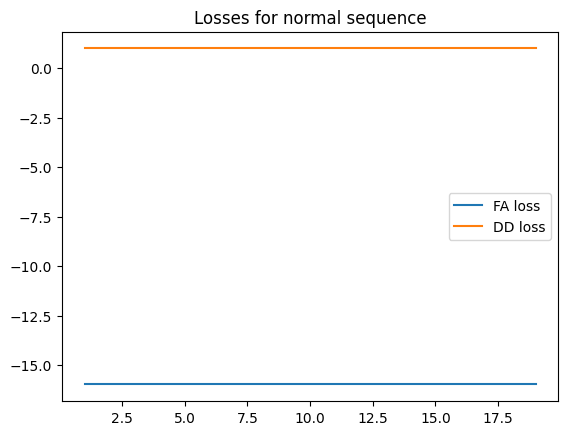

In [16]:
plt.figure()
plt.plot(fa_losses_norm_dict.keys(), fa_losses_norm_dict.values(), label="FA loss")
plt.plot(dd_losses_norm_dict.keys(), dd_losses_norm_dict.values(), label="DD loss")
plt.title("Losses for normal sequence")
plt.legend()
plt.show()

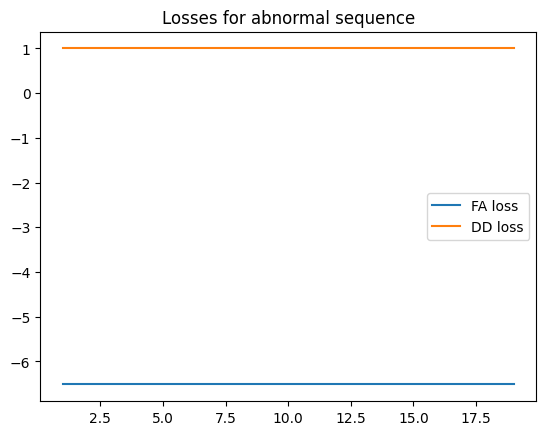

In [20]:
plt.figure()
plt.plot(fa_losses_cp_dict.keys(), fa_losses_cp_dict.values(), label="FA loss")
plt.plot(dd_losses_cp_dict.keys(), dd_losses_cp_dict.values(), label="DD loss")
plt.title("Losses for abnormal sequence")
plt.legend()

# Synthetic 1D

In [61]:
model_type = "seq2seq"

experiments_name = "synthetic_1D"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

args_config["learning"]["epochs"] = 100

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()

val_dataloader_shuffle = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [27]:
SEED = 0
fix_seeds(SEED)

core_model = BaseRnn(
    input_size=args_config["model"]["input_size"],
    hidden_dim=args_config["model"]["hidden_dim"],
    n_layers=args_config["model"]["n_layers"],
    drop_prob=args_config["model"]["drop_prob"],
    layer_norm=args_config["model"]["layer_norm"],
)

indid_model = CPDModel(
    loss_type="indid",
    args=args_config,
    model=core_model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
)

model_name = f"{experiments_name}_seq2seq_indid_seed_{SEED}"

indid_model

CPDModel(
  (model): BaseRnn(
    (lstm): LSTM(1, 4, batch_first=True, dropout=0.5)
    (linear): Linear(in_features=4, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (loss): CPDLoss()
)

In [ ]:
logger = CometLogger(
    api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    workspace="stalex2902",
    save_dir="logs/indid",
    project_name="indid",
    experiment_name=model_name,
    display_summary_level=0,
)

trainer = Trainer(
    max_epochs=args_config["learning"]["epochs"],
    gpus=0,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=args_config["learning"]["grad_clip"],
    logger=logger,
    callbacks=EarlyStopping(**args_config["early_stopping"]),
)

trainer.fit(indid_model)

torch.save(
    indid_model.model.state_dict(), f"saved_models/indid/synthetic_1D/{model_name}.pth"
)

In [29]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    indid_model,
    indid_model.val_dataloader(),
    threshold_list,
    device="cpu",
    model_type="seq2seq",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/5 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 5/5 [00:00<00:00, 38.92it/s]


TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 16, FP: 261, FN: 2, TP: 21, DELAY:0.33666667342185974, FP_DELAY:12.016666412353516, COVER: 0.8465230305989583
TN: 65, FP: 152, FN: 4, TP: 79, DELAY:0.6733333468437195, FP_DELAY:45.87666702270508, COVER: 0.9095908066259941
TN: 89, FP: 99, FN: 4, TP: 108, DELAY:0.70333331823349, FP_DELAY:61.22666549682617, COVER: 0.9402039982755628
TN: 105, FP: 67, FN: 4, TP: 124, DELAY:0.7200000286102295, FP_DELAY:72.34333038330078, COVER: 0.9588943212645673
TN: 115, FP: 51, FN: 4, TP: 130, DELAY:0.7233333587646484, FP_DEL

In [62]:
test_batch, test_labels = next(iter(val_dataloader_shuffle))
test_out = indid_model(test_batch)

test_labels.max(1)[0]

tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 1., 1.])

In [63]:
norm_idx = 0
cp_idx = 1

norm_probs = test_out[norm_idx]
norm_labels = test_labels[norm_idx]

cp_probs = test_out[cp_idx]
cp_labels = test_labels[cp_idx]

In [67]:
fa_losses_norm_dict = {}
dd_losses_norm_dict = {}

fa_losses_cp_dict = {}
dd_losses_cp_dict = {}

for T in range(2, 128):
    loss_func = CPDLoss(32)

    _, dd_losses, fa_losses = loss_func(
        test_out[:, :T].squeeze(), test_labels[:, :T].squeeze()
    )

    fa_losses_norm_dict[T] = fa_losses[norm_idx]
    dd_losses_norm_dict[T] = dd_losses[norm_idx]

    fa_losses_cp_dict[T] = fa_losses[cp_idx]
    dd_losses_cp_dict[T] = dd_losses[cp_idx]

In [71]:
dd_losses_cp_dict

{2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 1.8231886625289917,
 11: 2.2292802333831787,
 12: 2.3773860931396484,
 13: 2.4284753799438477,
 14: 2.44596004486084,
 15: 2.451937437057495,
 16: 2.4539806842803955,
 17: 2.454679012298584,
 18: 2.4549179077148438,
 19: 2.4549994468688965,
 20: 2.4550273418426514,
 21: 2.4550368785858154,
 22: 2.4550399780273438,
 23: 2.4550411701202393,
 24: 2.4550416469573975,
 25: 2.4550418853759766,
 26: 2.4550418853759766,
 27: 2.4550418853759766,
 28: 2.4550418853759766,
 29: 2.4550418853759766,
 30: 2.4550421237945557,
 31: 2.4550421237945557,
 32: 2.4550421237945557,
 33: 2.4550418853759766,
 34: 2.4550418853759766,
 35: 2.4550418853759766,
 36: 2.4550418853759766,
 37: 2.4550418853759766,
 38: 2.4550418853759766,
 39: 2.4550418853759766,
 40: 2.4550418853759766,
 41: 2.4550418853759766,
 42: 2.4550418853759766,
 43: 2.4550418853759766,
 44: 2.4550418853759766,
 45: 2.4550418853759766,
 46: 2.4550418853759766,
 47: 2.4550418853759766

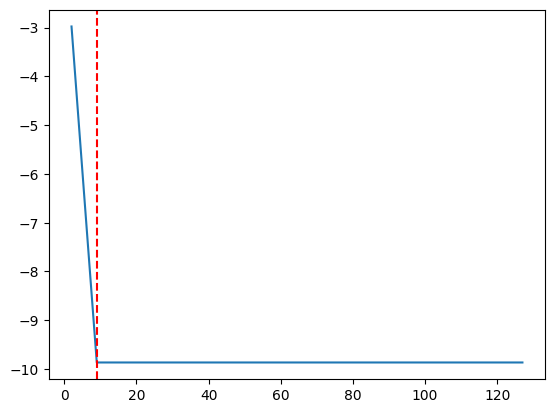

In [77]:
cp_idx = cp_labels.argmax().item()

plt.plot(fa_losses_cp_dict.keys(), fa_losses_cp_dict.values())
plt.axvline(cp_idx, linestyle="--", c="red")
plt.show()

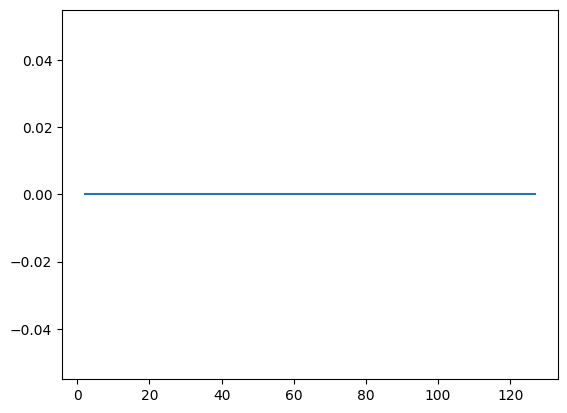

In [70]:
plt.plot(dd_losses_norm_dict.keys(), dd_losses_norm_dict.values());